# Machine Learning - Crime Predictor
explain we will do for 250, 500 and 1000 slice
say SMOTE
say feature importance
say grid search
review AUC, ROC, confusion matrix

Feature importance and random forest ideas from https://towardsdatascience.com/random-forest-in-python-24d0893d51c0 and https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py. We used https://datascienceplus.com/machine-learning-for-diabetes-with-python/ for ideas on how to compare training versus validation for pre and post smote data.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import altair as alt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np

## Load socioeconomic and crime dataset

In [2]:
violence_features_master = pd.read_csv("./DataSources/Income and Deprivation/violence_features_master.csv")
print(violence_features_master.shape)
violence_features_master.head()

(4823, 34)


,lsoa_code,borough,ldn_datastore_total,police_total,LSOA Code,lsoa_name,population,crime_per_1000,crime_per_1000_proportion,lad_code,...,no_qualifications_pct,degree_educated_pct,population_density,median_house_price,log_rent_social_pct,log_ethnic_other_pct,log_population_density,log_median_house_price,log_ethnic_black_pct,log_ethnic_asian_pct
0,E01000006,Barking and Dagenham,27,50.0,E01000006,Barking and Dagenham 016A,2094,12.893983,0.218365,E09000002,...,0.182,0.329,0.144255,0.034776,-3.411248,-3.528124,-1.936171,-3.358826,-2.263997,-0.682052
1,E01000007,Barking and Dagenham,130,188.0,E01000007,Barking and Dagenham 015A,2502,51.958433,0.879936,E09000002,...,0.152,0.323,0.093529,0.010444,-0.898942,-3.905574,-2.369485,-4.561768,-1.274199,-1.135220
2,E01000008,Barking and Dagenham,23,89.0,E01000008,Barking and Dagenham 015B,1597,14.402004,0.243903,E09000002,...,0.211,0.242,0.100393,0.012705,-0.406466,-3.371840,-2.298662,-4.365794,-0.989502,-1.487060
3,E01000009,Barking and Dagenham,52,115.0,E01000009,Barking and Dagenham 016B,1929,26.956973,0.456527,E09000002,...,0.186,0.350,0.167821,0.012705,-1.584745,-3.588608,-1.784857,-4.365794,-2.051083,-0.560744
4,E01000010,Barking and Dagenham,211,430.0,E01000010,Barking and Dagenham 015C,3579,58.955015,0.998426,E09000002,...,0.122,0.449,0.111747,0.013775,-1.343235,-3.408265,-2.191522,-4.284878,-1.588531,-0.857324


## Remove highly correlated features
We don't want the model to overfit on the training data as this will mean it is less able to generalise to unseen data and one method for reducing the level of overfitting is to prune the number of features the model is trained on. We will use two basic approaches for feature pruning, which are to remove variables which highly correlate with other variables and to remove features that are not important for prediction. We will do the first of these steps now:

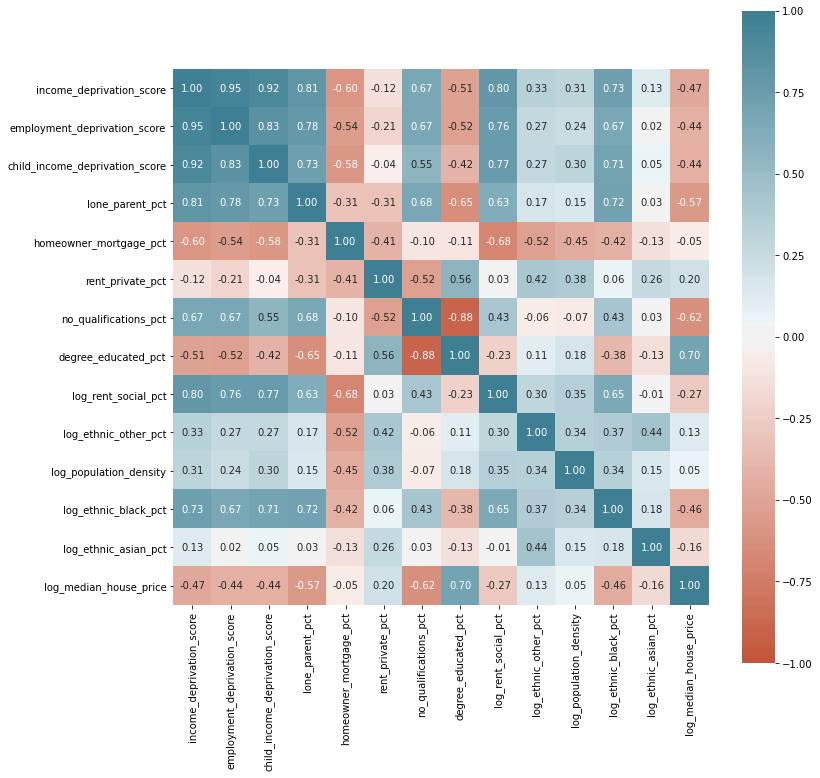

In [3]:
# extract numeric data
dataset = violence_features_master[['income_deprivation_score',
                                'employment_deprivation_score',
                                'child_income_deprivation_score',
                                'lone_parent_pct',
                                'homeowner_mortgage_pct',
                                'rent_private_pct',
                                'no_qualifications_pct',
                                'degree_educated_pct',
                                'log_rent_social_pct',
                                'log_ethnic_other_pct',
                                'log_population_density',
                                'log_ethnic_black_pct',
                                'log_ethnic_asian_pct',
                                'log_median_house_price']].copy()

# derive and plot correlations
corr = dataset.corr()
plt.figure(figsize = (12,12))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    fmt=".2f"
)

## Comments
We can see that income, employment and child income are correlations greater than 0.9 and so remove 2 of the three from the model. I will just retain income_deprivation.

Now we create snapshots based on our 250, 500 cohorts and for each we will create an original and rebalanced dataset (using SMOTE). For all datasets we will review feature importance, create predictions, review model performance and then assess our results.

First we create our machine learning functions that we will later use

### Machine learning functions

#### 1. Create a dataset with desired cohort size

In [4]:
def create_snapshot(violence_features_master, cohort_size, feature_list):
    violence_features = violence_features_master.copy()
    
    print("<---- creating dataset with a high crime cohort size = {} ---->".format(cohort_size))
    
    violence_features['high_violence'] = 0
    
    print("shape of violence_features")
    print(violence_features.shape)
    top_n = violence_features.sort_values(by='crime_per_1000', ascending=False)[:cohort_size]
    top_n.high_violence = 1
       
    print("shape of top {} cohort".format(cohort_size))
    print(top_n.shape)
    the_rest = violence_features.sort_values(by='crime_per_1000', ascending=False)[cohort_size:]
    
    print("shape of remaining cohort")
    print(the_rest.shape)

    violence_features_new = top_n.copy()
    violence_features_new = violence_features_new.append(the_rest, ignore_index=True)

    print("shape of recombined cohort")
    print(violence_features_new.shape)

    # just take numeric fields
    dataset = violence_features_new[feature_list].copy()
    
    print("shape of recombined cohort, with just numeric fields")
    print(dataset.shape)
    
    print("<---- dataset with a high crime cohort size = {} created ---->\n".format(cohort_size))
    
    return dataset

#### 2. Generate original and rebalanced test and train datasets

In [5]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN

def get_smote(train_features, train_labels):
    X_resampled, y_resampled = SMOTE().fit_resample(train_features, train_labels)
    
    prior_yes = np.sum(train_labels==1)
    prior_no = np.sum(train_labels==0)
    post_yes =  np.sum(y_resampled==1)
    post_no = np.sum(y_resampled==0)

    labels = ['high crime', 'low crime', 'high crime(SMOTE)', 'low crime (SMOTE)']
    counts = [prior_yes, prior_no, post_yes, post_no]

    plt.figure()
    plt.title('labels before and after rebalancing (SMOTE)')
    plt.bar(labels, counts)
    plt.xticks(labels, rotation=45)
    plt.show()
    
    return X_resampled, y_resampled


def get_test_train_data(dataset):
    # Labels are the values we want to predict
    labels = np.array(dataset['high_violence'])
    # Remove the labels from the features
    # axis 1 refers to the columns
    dataset= dataset.drop('high_violence', axis = 1)
    # Saving feature names for later use
    feature_list = list(dataset.columns)
    # Convert to numpy array
    features = np.array(dataset)
    
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)
    
    print('Training Features Shape:', train_features.shape)
    print('Training Labels Shape:', train_labels.shape)
    print('Testing Features Shape:', test_features.shape)
    print('Testing Labels Shape:', test_labels.shape)
    
    X_resampled, y_resampled = get_smote(train_features, train_labels)
    
    return train_features, test_features, train_labels, test_labels, X_resampled, y_resampled

#### 3. Review feature importance and check model reasonableness

In [6]:
from sklearn.ensemble import RandomForestClassifier

def feature_importance(rf, data_in):
    
    # remove the label field ('high violence')
    dataset = data_in.copy()
    dataset.drop('high_violence', axis=1, inplace=True)
    
    # Calculate feature importances
    importances = rf.feature_importances_
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]
    
    feature_list = list(dataset.columns)

    # Rearrange feature names so they match the sorted feature importances
    names = [feature_list[i] for i in indices]
    
    # Barplot: Add bars
    plt.bar(range(dataset.shape[1]), importances[indices])
    # Add feature names as x-axis labels
    plt.xticks(range(dataset.shape[1]), names, rotation=90, fontsize = 8)
    # Create plot title
    plt.title("Feature Importance")
    # Show plot
    plt.show()

def model_reasonableness(train_features, test_features, train_labels, test_labels):
    
    print("<------ running random forest model ------->\n")
    # Instantiate model with 1000 decision trees
    rf = RandomForestClassifier(n_estimators = 1000, oob_score = True,
                           bootstrap = True, random_state = 42)

    # Train the model on training data
    rf.fit(train_features, train_labels);

    print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(train_features, train_labels), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(test_features, test_labels)))
        
    print("\n<------ finished running random forest model ------->")
    
    return rf

#### 4. Produce and plot model accuracy measures

In [7]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


def RF_performance_reporting(rf, test_features, test_labels, y_pred, description, print_output=True):    
    # I now want to create a confusion matrix and to do this I first have to 
    # change my model output from a probability to a label 1 or 0
   
    accuracy = accuracy_score(test_labels, y_pred)
    precision = precision_score(test_labels, y_pred)
    recall = recall_score(test_labels, y_pred)
    roc_auc = roc_auc_score(test_labels, y_pred)
    cm = confusion_matrix(test_labels, y_pred)
    
    tn, fp, fn, tp = confusion_matrix(test_labels,y_pred).ravel()
    
    if print_output:
        
        print('------------------------------------------------------------------')
        print('Printing performance metrics for ' + description)
        print('------------------------------------------------------------------\n')
        print('prediction accuracy', accuracy)
        print('precision', precision)
        print('recall', recall)
        print('Area under the curve score', roc_auc)   
        print('\n')  

        fpr, tpr, thresholds = roc_curve(test_labels, y_pred)

        plot_confusion_matrix(rf, test_features, test_labels)  
        plt.show() 
        
        metrics.plot_roc_curve(rf, test_features, test_labels)  
        plt.show()
        
    return accuracy, precision, recall, roc_auc, tn, fp, fn, tp

## Model experiments
Now run the model under a range of conditions in order to deduce the best combination of cohort_size, features and unbalanced vs rebalanced datasets.

In [8]:
rf_results_df = pd.DataFrame(columns=['description', 
                                      'accuracy', 
                                      'precision', 
                                      'recall', 
                                      'auc', 
                                      'true positive',
                                      'false positive',
                                      'true negative',
                                      'false negative'])

### Option 1:
- cohort_size = 250
- all features (I did not remove child_income and employment deprivation)

<---- creating dataset with a high crime cohort size = 250 ---->
shape of violence_features
(4823, 35)
shape of top 250 cohort
(250, 35)
shape of remaining cohort
(4573, 35)
shape of recombined cohort
(4823, 35)
shape of recombined cohort, with just numeric fields
(4823, 15)
<---- dataset with a high crime cohort size = 250 created ---->

Training Features Shape: (3617, 14)
Training Labels Shape: (3617,)
Testing Features Shape: (1206, 14)
Testing Labels Shape: (1206,)


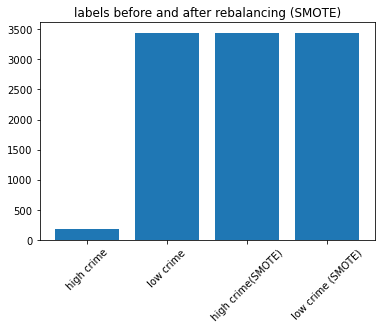

<------ running random forest model ------->

R^2 Training Score: 1.00 
OOB Score: 0.95 
R^2 Validation Score: 0.94

<------ finished running random forest model ------->
<------ running random forest model ------->

R^2 Training Score: 1.00 
OOB Score: 0.97 
R^2 Validation Score: 0.92

<------ finished running random forest model ------->


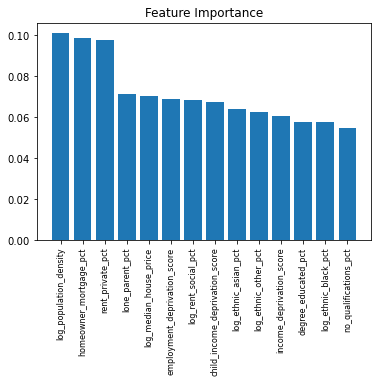

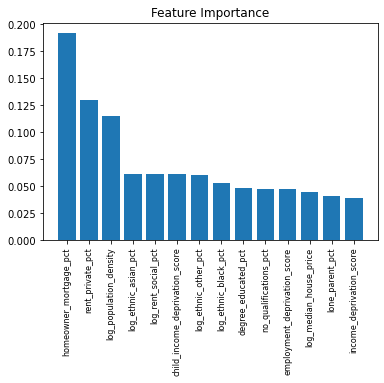

------------------------------------------------------------------
Printing performance metrics for normal
------------------------------------------------------------------

prediction accuracy 0.9378109452736318
precision 0.6
recall 0.039473684210526314
Area under the curve score 0.5188518863530508




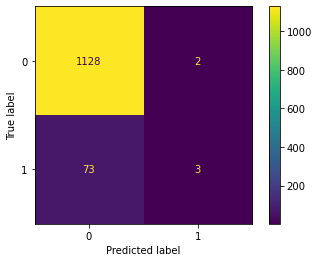

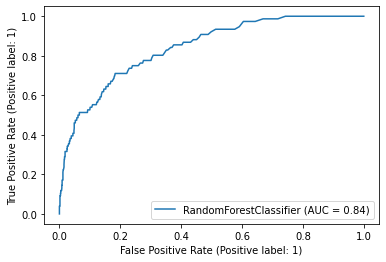

------------------------------------------------------------------
Printing performance metrics for SMOTE
------------------------------------------------------------------

prediction accuracy 0.9170812603648425
precision 0.36363636363636365
recall 0.42105263157894735
Area under the curve score 0.6857475547275268




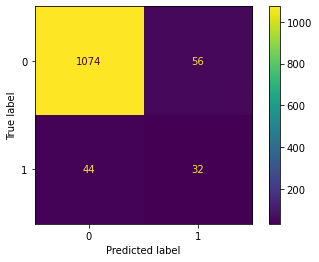

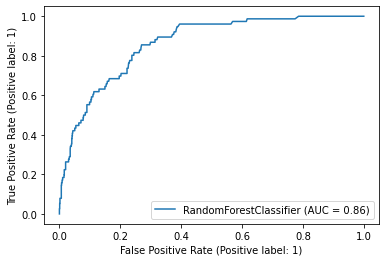

In [9]:
# create feature list without income_deprivation and employment_deprivation
feature_list = ['income_deprivation_score',
                'employment_deprivation_score',
                'child_income_deprivation_score',
                'lone_parent_pct',
                'homeowner_mortgage_pct',
                'rent_private_pct',
                'no_qualifications_pct',
                'degree_educated_pct',
                'log_rent_social_pct',
                'log_ethnic_other_pct',
                'log_population_density',
                'log_ethnic_black_pct',
                'log_ethnic_asian_pct',
                'log_median_house_price',
                'high_violence']

cohort_size = 250
dataset = create_snapshot(violence_features_master, cohort_size, feature_list)
train_features, test_features, train_labels, test_labels, X_resampled, y_resampled = get_test_train_data(dataset)

# test with and without SMOTE
rf = model_reasonableness(train_features, test_features, train_labels, test_labels)
rf_smote = model_reasonableness(X_resampled, test_features, y_resampled, test_labels)

feature_importance(rf, dataset)    
feature_importance(rf_smote, dataset)

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
accuracy, precision, recall, roc_auc, tn, fp, fn, tp = RF_performance_reporting(rf, test_features, test_labels, 
                                                                                predictions, 'normal', print_output=True)

rf_result_row = {'description': 'cohort(250), all features, unbalanced', 
                 'accuracy': accuracy, 
                 'precision': precision,
                 'recall': recall,
                 'auc': roc_auc, 
                 'true positive': tp, 
                 'false positive': fp, 
                 'true negative': tn, 
                 'false negative': fn}

rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

predictions_smote = rf_smote.predict(test_features)
accuracy, precision, recall, roc_auc, tn, fp, fn, tp = RF_performance_reporting(rf_smote, 
                                                                                test_features, 
                                                                                test_labels, 
                                                                                predictions_smote, 'SMOTE', 
                                                                                print_output=True)

rf_result_row = {'description': 'cohort(250), all features, rebalanced', 
                 'accuracy': accuracy, 
                 'precision': precision,
                 'recall': recall,
                 'auc': roc_auc, 
                 'true positive': tp, 
                 'false positive': fp, 
                 'true negative': tn, 
                 'false negative': fn}

rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

### Comments
It's very clear that recall is non existent without rebalancing the dataset so we will SMOTE the dataset but now we will run again, having removed 'employment_deprivation_score' and 'child_income_deprivation_score' to see if our prediction improves

### Option 2:
- cohort_size = 250
- rebalanced dataset
- remove child_income and employment deprivation

<---- creating dataset with a high crime cohort size = 250 ---->
shape of violence_features
(4823, 35)
shape of top 250 cohort
(250, 35)
shape of remaining cohort
(4573, 35)
shape of recombined cohort
(4823, 35)
shape of recombined cohort, with just numeric fields
(4823, 13)
<---- dataset with a high crime cohort size = 250 created ---->

Training Features Shape: (3617, 12)
Training Labels Shape: (3617,)
Testing Features Shape: (1206, 12)
Testing Labels Shape: (1206,)


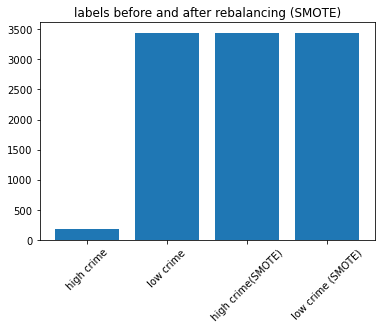

<------ running random forest model ------->

R^2 Training Score: 1.00 
OOB Score: 0.96 
R^2 Validation Score: 0.92

<------ finished running random forest model ------->


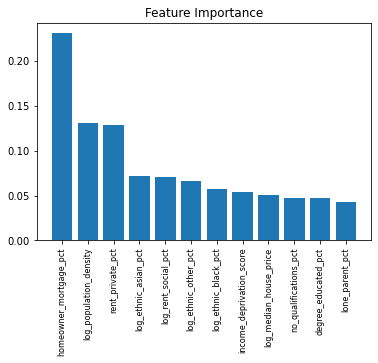

------------------------------------------------------------------
Printing performance metrics for SMOTE
------------------------------------------------------------------

prediction accuracy 0.9170812603648425
precision 0.3695652173913043
recall 0.4473684210526316
Area under the curve score 0.6980204937121566




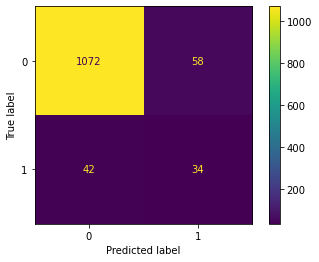

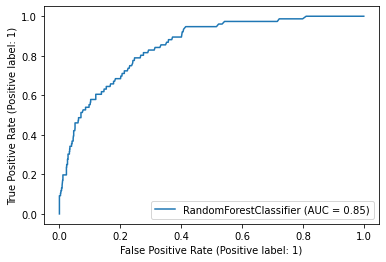

In [10]:
# create feature list without income_deprivation and employment_deprivation
feature_list = ['income_deprivation_score',
                'lone_parent_pct',
                'homeowner_mortgage_pct',
                'rent_private_pct',
                'no_qualifications_pct',
                'degree_educated_pct',
                'log_rent_social_pct',
                'log_ethnic_other_pct',
                'log_population_density',
                'log_ethnic_black_pct',
                'log_ethnic_asian_pct',
                'log_median_house_price',
                'high_violence']

cohort_size = 250
dataset = create_snapshot(violence_features_master, cohort_size, feature_list)
train_features, test_features, train_labels, test_labels, X_resampled, y_resampled = get_test_train_data(dataset)

# test with SMOTE only
rf_smote = model_reasonableness(X_resampled, test_features, y_resampled, test_labels)
feature_importance(rf_smote, dataset)

predictions_smote = rf_smote.predict(test_features)
accuracy, precision, recall, roc_auc, tn, fp, fn, tp = RF_performance_reporting(rf_smote, 
                                                                                test_features, 
                                                                                test_labels, 
                                                                                predictions_smote, 
                                                                                'SMOTE', print_output=True)

rf_result_row = {'description': 'cohort(250), no child_income|employment deprivation, rebalanced', 
                 'accuracy': accuracy, 
                 'precision': precision,
                 'recall': recall,
                 'auc': roc_auc, 
                 'true positive': tp, 
                 'false positive': fp, 
                 'true negative': tn, 
                 'false negative': fn}

rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

### Comments
Interestingly precision and recall were better when including 'employment_deprivation_score' and 'child_income_deprivation_score' so retain these values if we stick with cohort size = 250

### Option 3:
- cohort_size = 500
- rebalanced dataset
- include child_income and employment deprivation

<---- creating dataset with a high crime cohort size = 500 ---->
shape of violence_features
(4823, 35)
shape of top 500 cohort
(500, 35)
shape of remaining cohort
(4323, 35)
shape of recombined cohort
(4823, 35)
shape of recombined cohort, with just numeric fields
(4823, 15)
<---- dataset with a high crime cohort size = 500 created ---->

Training Features Shape: (3617, 14)
Training Labels Shape: (3617,)
Testing Features Shape: (1206, 14)
Testing Labels Shape: (1206,)


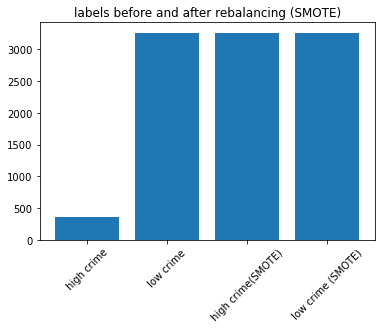

<------ running random forest model ------->

R^2 Training Score: 1.00 
OOB Score: 0.94 
R^2 Validation Score: 0.87

<------ finished running random forest model ------->


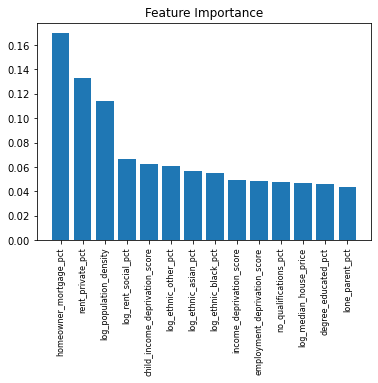

------------------------------------------------------------------
Printing performance metrics for SMOTE
------------------------------------------------------------------

prediction accuracy 0.867330016583748
precision 0.44155844155844154
recall 0.4788732394366197
Area under the curve score 0.6990230858837234




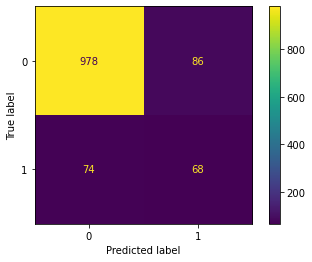

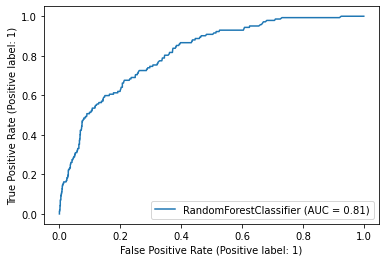

In [11]:
# create feature list without income_deprivation and employment_deprivation
feature_list = ['income_deprivation_score',
                'employment_deprivation_score',
                'child_income_deprivation_score',
                'lone_parent_pct',
                'homeowner_mortgage_pct',
                'rent_private_pct',
                'no_qualifications_pct',
                'degree_educated_pct',
                'log_rent_social_pct',
                'log_ethnic_other_pct',
                'log_population_density',
                'log_ethnic_black_pct',
                'log_ethnic_asian_pct',
                'log_median_house_price',
                'high_violence']

cohort_size = 500
dataset = create_snapshot(violence_features_master, cohort_size, feature_list)
train_features, test_features, train_labels, test_labels, X_resampled, y_resampled = get_test_train_data(dataset)

# test with SMOTE only
rf_smote = model_reasonableness(X_resampled, test_features, y_resampled, test_labels)
feature_importance(rf_smote, dataset)

predictions_smote = rf_smote.predict(test_features)
accuracy, precision, recall, roc_auc, tn, fp, fn, tp = RF_performance_reporting(rf_smote, 
                                                                                test_features, 
                                                                                test_labels, 
                                                                                predictions_smote, 
                                                                                'SMOTE', print_output=True)

rf_result_row = {'description': 'cohort(500), all features, rebalanced', 
                 'accuracy': accuracy, 
                 'precision': precision,
                 'recall': recall,
                 'auc': roc_auc, 
                 'true positive': tp, 
                 'false positive': fp, 
                 'true negative': tn, 
                 'false negative': fn}

rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

### Comments
Precision and recall are better than with cohort size = 250, so now try having removed 'employment_deprivation_score' and 'child_income_deprivation_score' to see if our prediction improves

### Option 4:
- cohort_size = 500
- rebalanced dataset
- removed child_income and employment deprivation

<---- creating dataset with a high crime cohort size = 500 ---->
shape of violence_features
(4823, 35)
shape of top 500 cohort
(500, 35)
shape of remaining cohort
(4323, 35)
shape of recombined cohort
(4823, 35)
shape of recombined cohort, with just numeric fields
(4823, 13)
<---- dataset with a high crime cohort size = 500 created ---->

Training Features Shape: (3617, 12)
Training Labels Shape: (3617,)
Testing Features Shape: (1206, 12)
Testing Labels Shape: (1206,)


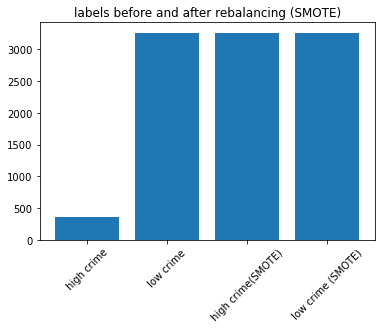

<------ running random forest model ------->

R^2 Training Score: 1.00 
OOB Score: 0.94 
R^2 Validation Score: 0.86

<------ finished running random forest model ------->


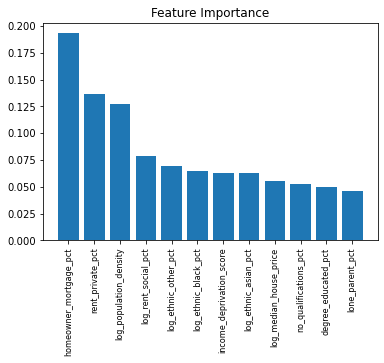

------------------------------------------------------------------
Printing performance metrics for SMOTE
------------------------------------------------------------------

prediction accuracy 0.8623548922056384
precision 0.42207792207792205
recall 0.45774647887323944
Area under the curve score 0.687049931165943




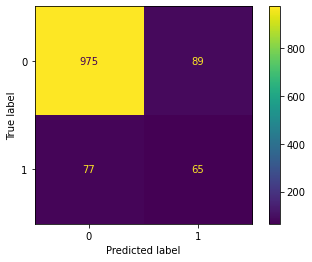

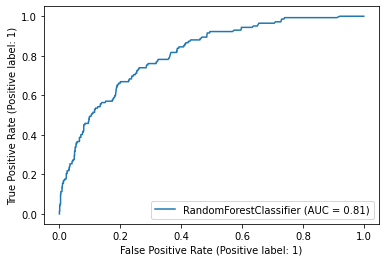

In [12]:
# create feature list without income_deprivation and employment_deprivation
feature_list = ['income_deprivation_score',
                'lone_parent_pct',
                'homeowner_mortgage_pct',
                'rent_private_pct',
                'no_qualifications_pct',
                'degree_educated_pct',
                'log_rent_social_pct',
                'log_ethnic_other_pct',
                'log_population_density',
                'log_ethnic_black_pct',
                'log_ethnic_asian_pct',
                'log_median_house_price',
                'high_violence']

cohort_size = 500
dataset = create_snapshot(violence_features_master, cohort_size, feature_list)
train_features, test_features, train_labels, test_labels, X_resampled, y_resampled = get_test_train_data(dataset)

# test with SMOTE only
rf_smote = model_reasonableness(X_resampled, test_features, y_resampled, test_labels)
feature_importance(rf_smote, dataset)

predictions_smote = rf_smote.predict(test_features)
accuracy, precision, recall, roc_auc, tn, fp, fn, tp = RF_performance_reporting(rf_smote, 
                                                                                test_features, 
                                                                                test_labels, 
                                                                                predictions_smote, 
                                                                                'SMOTE', print_output=True)

rf_result_row = {'description': 'cohort(500), no child_income|employment deprivation, rebalanced', 
                 'accuracy': accuracy, 
                 'precision': precision,
                 'recall': recall,
                 'auc': roc_auc, 
                 'true positive': tp, 
                 'false positive': fp, 
                 'true negative': tn, 
                 'false negative': fn}

rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

### Comments
Once again, keeping 'employment_deprivation_score' and 'child_income_deprivation_score' results in better recall and precision so retain those. Now check our best model, having removed the 5 least important features

### Option 5:
- cohort_size = 500
- rebalanced dataset
- include child_income and employment deprivation
- remove
    - log_median_house_price
    - log_ethnic_black_pct
    - degree_educated_pct
    - no_qualifications_pct
    - lone_parent_pct

<---- creating dataset with a high crime cohort size = 500 ---->
shape of violence_features
(4823, 35)
shape of top 500 cohort
(500, 35)
shape of remaining cohort
(4323, 35)
shape of recombined cohort
(4823, 35)
shape of recombined cohort, with just numeric fields
(4823, 10)
<---- dataset with a high crime cohort size = 500 created ---->

Training Features Shape: (3617, 9)
Training Labels Shape: (3617,)
Testing Features Shape: (1206, 9)
Testing Labels Shape: (1206,)


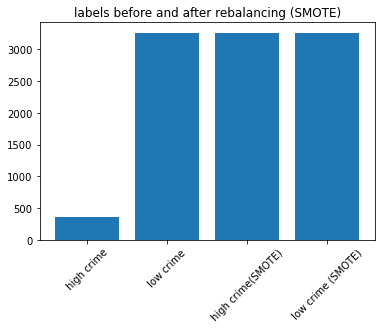

<------ running random forest model ------->

R^2 Training Score: 1.00 
OOB Score: 0.93 
R^2 Validation Score: 0.85

<------ finished running random forest model ------->


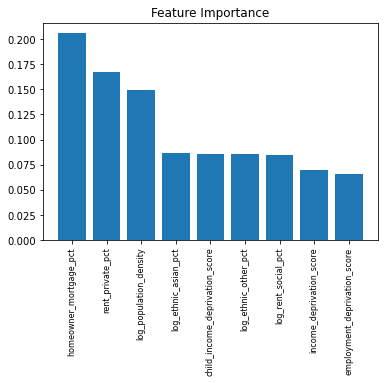

------------------------------------------------------------------
Printing performance metrics for SMOTE
------------------------------------------------------------------

prediction accuracy 0.8499170812603648
precision 0.3968253968253968
recall 0.528169014084507
Area under the curve score 0.710513078470825




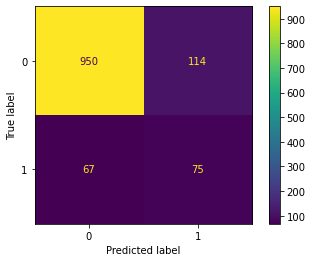

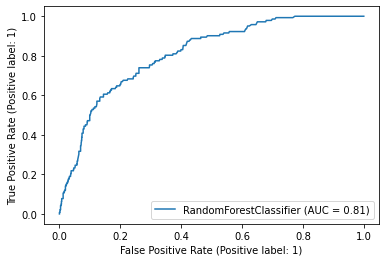

In [13]:
# create feature list without income_deprivation and employment_deprivation
feature_list = ['income_deprivation_score',
                'employment_deprivation_score',
                'child_income_deprivation_score',
                'homeowner_mortgage_pct',
                'rent_private_pct',
                'log_rent_social_pct',
                'log_ethnic_other_pct',
                'log_population_density',
                'log_ethnic_asian_pct',
                'high_violence']

cohort_size = 500
dataset = create_snapshot(violence_features_master, cohort_size, feature_list)
train_features, test_features, train_labels, test_labels, X_resampled, y_resampled = get_test_train_data(dataset)

# test with SMOTE only
rf_smote = model_reasonableness(X_resampled, test_features, y_resampled, test_labels)
feature_importance(rf_smote, dataset)

predictions_smote = rf_smote.predict(test_features)
accuracy, precision, recall, roc_auc, tn, fp, fn, tp = RF_performance_reporting(rf_smote, 
                                                                                test_features, 
                                                                                test_labels, 
                                                                                predictions_smote, 
                                                                                'SMOTE', print_output=True)

rf_result_row = {'description': 'cohort(500), no median_house|ethnic_black|degree|no quals|lone parent, rebalanced', 
                 'accuracy': accuracy, 
                 'precision': precision,
                 'recall': recall,
                 'auc': roc_auc, 
                 'true positive': tp, 
                 'false positive': fp, 
                 'true negative': tn, 
                 'false negative': fn}

rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

### Option 6:
Because we have increased the cohort size to about 20-22% of the population we will see what the results look like with and without SMOTE.
- cohort_size = 1000
- unbalanced and rebalanced
- all features (I did not remove child_income and employment deprivation)

<---- creating dataset with a high crime cohort size = 1000 ---->
shape of violence_features
(4823, 35)
shape of top 1000 cohort
(1000, 35)
shape of remaining cohort
(3823, 35)
shape of recombined cohort
(4823, 35)
shape of recombined cohort, with just numeric fields
(4823, 15)
<---- dataset with a high crime cohort size = 1000 created ---->

Training Features Shape: (3617, 14)
Training Labels Shape: (3617,)
Testing Features Shape: (1206, 14)
Testing Labels Shape: (1206,)


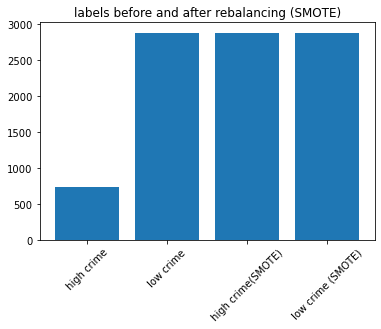

<------ running random forest model ------->

R^2 Training Score: 1.00 
OOB Score: 0.82 
R^2 Validation Score: 0.82

<------ finished running random forest model ------->
<------ running random forest model ------->

R^2 Training Score: 1.00 
OOB Score: 0.88 
R^2 Validation Score: 0.77

<------ finished running random forest model ------->


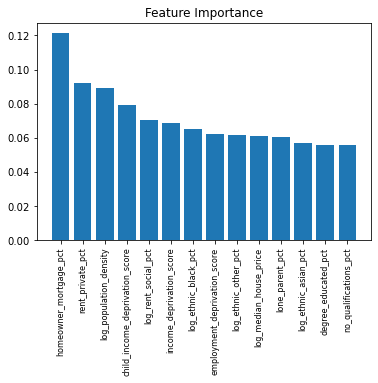

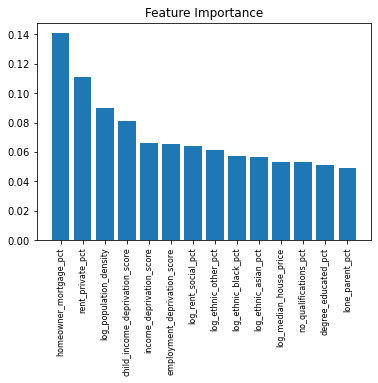

------------------------------------------------------------------
Printing performance metrics for normal
------------------------------------------------------------------

prediction accuracy 0.8217247097844113
precision 0.7203389830508474
recall 0.31835205992509363
Area under the curve score 0.6416041449785214




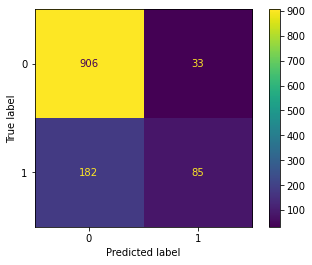

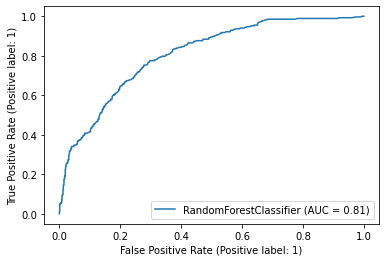

------------------------------------------------------------------
Printing performance metrics for SMOTE
------------------------------------------------------------------

prediction accuracy 0.7653399668325042
precision 0.47419354838709676
recall 0.550561797752809
Area under the curve score 0.6884864366825814




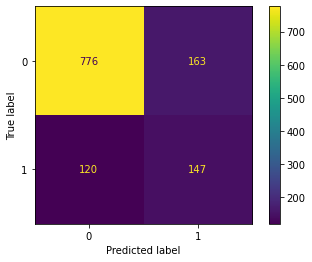

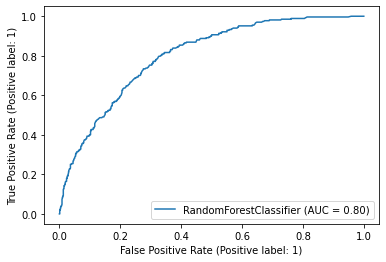

In [14]:
# create feature list without income_deprivation and employment_deprivation
feature_list = ['income_deprivation_score',
                'employment_deprivation_score',
                'child_income_deprivation_score',
                'lone_parent_pct',
                'homeowner_mortgage_pct',
                'rent_private_pct',
                'no_qualifications_pct',
                'degree_educated_pct',
                'log_rent_social_pct',
                'log_ethnic_other_pct',
                'log_population_density',
                'log_ethnic_black_pct',
                'log_ethnic_asian_pct',
                'log_median_house_price',
                'high_violence']

cohort_size = 1000
dataset = create_snapshot(violence_features_master, cohort_size, feature_list)
train_features, test_features, train_labels, test_labels, X_resampled, y_resampled = get_test_train_data(dataset)

# test with and without SMOTE
rf = model_reasonableness(train_features, test_features, train_labels, test_labels)
rf_smote = model_reasonableness(X_resampled, test_features, y_resampled, test_labels)

feature_importance(rf, dataset)    
feature_importance(rf_smote, dataset)

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
accuracy, precision, recall, roc_auc, tn, fp, fn, tp = RF_performance_reporting(rf, test_features, test_labels, 
                                                                                predictions, 'normal', print_output=True)

rf_result_row = {'description': 'cohort(1000), all features, unbalanced', 
                 'accuracy': accuracy, 
                 'precision': precision,
                 'recall': recall,
                 'auc': roc_auc, 
                 'true positive': tp, 
                 'false positive': fp, 
                 'true negative': tn, 
                 'false negative': fn}

rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

predictions_smote = rf_smote.predict(test_features)
accuracy, precision, recall, roc_auc, tn, fp, fn, tp = RF_performance_reporting(rf_smote, 
                                                                                test_features, 
                                                                                test_labels, 
                                                                                predictions_smote, 
                                                                                'SMOTE', print_output=True)

rf_result_row = {'description': 'cohort(1000), all features, rebalanced', 
                 'accuracy': accuracy, 
                 'precision': precision,
                 'recall': recall,
                 'auc': roc_auc, 
                 'true positive': tp, 
                 'false positive': fp, 
                 'true negative': tn, 
                 'false negative': fn}

rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

From above we can see unbalanced data has better precision but poorer recall and so it confirms that we need to rebalance the data to get better results (recall is more important because we want to identify areas that have more crime) 

### Option 7:
- cohort_size = 1000
- rebalanced
- all features (remove child_income and employment deprivation)

<---- creating dataset with a high crime cohort size = 1000 ---->
shape of violence_features
(4823, 35)
shape of top 1000 cohort
(1000, 35)
shape of remaining cohort
(3823, 35)
shape of recombined cohort
(4823, 35)
shape of recombined cohort, with just numeric fields
(4823, 13)
<---- dataset with a high crime cohort size = 1000 created ---->

Training Features Shape: (3617, 12)
Training Labels Shape: (3617,)
Testing Features Shape: (1206, 12)
Testing Labels Shape: (1206,)


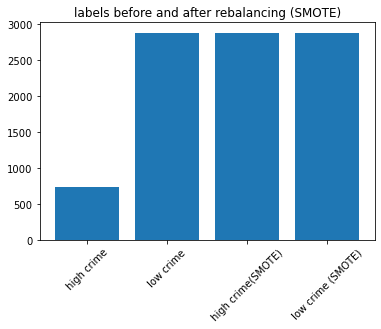

<------ running random forest model ------->

R^2 Training Score: 1.00 
OOB Score: 0.88 
R^2 Validation Score: 0.77

<------ finished running random forest model ------->


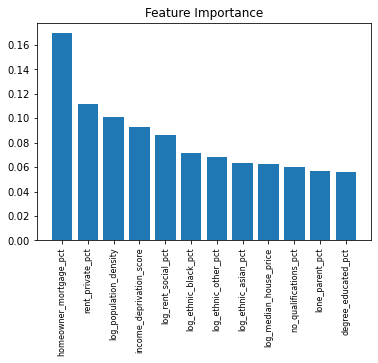

------------------------------------------------------------------
Printing performance metrics for SMOTE
------------------------------------------------------------------

prediction accuracy 0.7661691542288557
precision 0.47540983606557374
recall 0.5430711610486891
Area under the curve score 0.6863385624199781




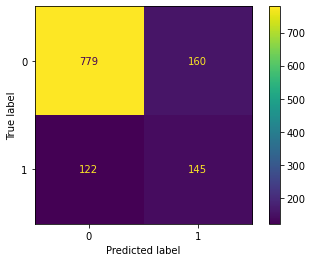

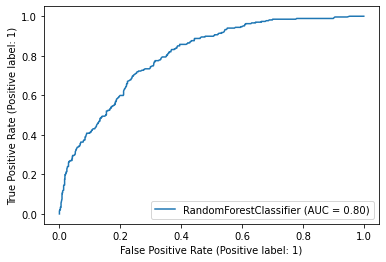

In [15]:
# create feature list without income_deprivation and employment_deprivation
feature_list = ['income_deprivation_score',
                'lone_parent_pct',
                'homeowner_mortgage_pct',
                'rent_private_pct',
                'no_qualifications_pct',
                'degree_educated_pct',
                'log_rent_social_pct',
                'log_ethnic_other_pct',
                'log_population_density',
                'log_ethnic_black_pct',
                'log_ethnic_asian_pct',
                'log_median_house_price',
                'high_violence']

cohort_size = 1000
dataset = create_snapshot(violence_features_master, cohort_size, feature_list)
train_features, test_features, train_labels, test_labels, X_resampled, y_resampled = get_test_train_data(dataset)

# test with SMOTE only
rf_smote = model_reasonableness(X_resampled, test_features, y_resampled, test_labels)
feature_importance(rf_smote, dataset)

predictions_smote = rf_smote.predict(test_features)
accuracy, precision, recall, roc_auc, tn, fp, fn, tp = RF_performance_reporting(rf_smote, 
                                                                                test_features, 
                                                                                test_labels, 
                                                                                predictions_smote, 
                                                                                'SMOTE', print_output=True)

rf_result_row = {'description': 'cohort(1000), no child income|employment deprivation, rebalanced', 
                 'accuracy': accuracy, 
                 'precision': precision,
                 'recall': recall,
                 'auc': roc_auc, 
                 'true positive': tp, 
                 'false positive': fp, 
                 'true negative': tn, 
                 'false negative': fn}

rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

### Option 8:
- cohort_size = 1000
- rebalanced dataset
- include child_income and employment deprivation
- remove
    - log_median_house_price
    - log_ethnic_black_pct
    - degree_educated_pct
    - no_qualifications_pct
    - lone_parent_pct

<---- creating dataset with a high crime cohort size = 1000 ---->
shape of violence_features
(4823, 35)
shape of top 1000 cohort
(1000, 35)
shape of remaining cohort
(3823, 35)
shape of recombined cohort
(4823, 35)
shape of recombined cohort, with just numeric fields
(4823, 10)
<---- dataset with a high crime cohort size = 1000 created ---->

Training Features Shape: (3617, 9)
Training Labels Shape: (3617,)
Testing Features Shape: (1206, 9)
Testing Labels Shape: (1206,)


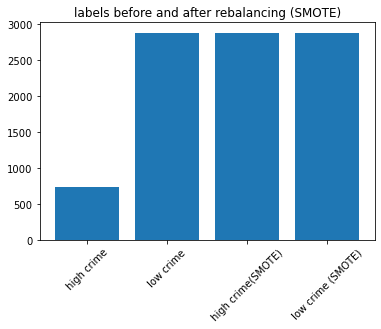

<------ running random forest model ------->

R^2 Training Score: 1.00 
OOB Score: 0.87 
R^2 Validation Score: 0.76

<------ finished running random forest model ------->


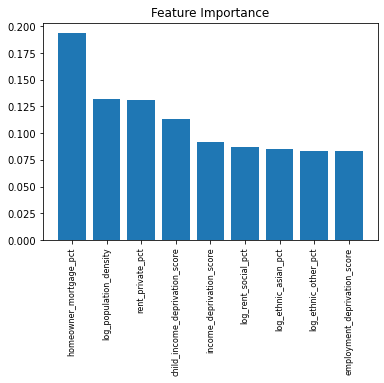

------------------------------------------------------------------
Printing performance metrics for SMOTE
------------------------------------------------------------------

prediction accuracy 0.7570480928689884
precision 0.46130952380952384
recall 0.5805243445692884
Area under the curve score 0.6938830455540796




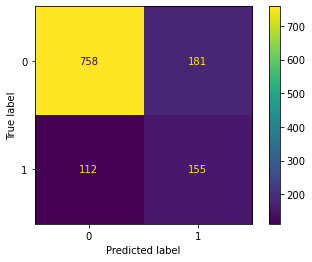

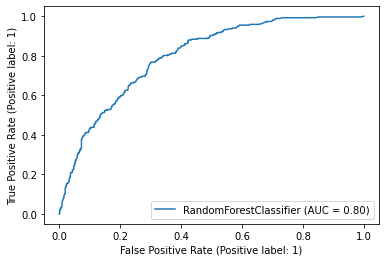

In [16]:
# create feature list without income_deprivation and employment_deprivation
feature_list = ['income_deprivation_score',
                'employment_deprivation_score',
                'child_income_deprivation_score',
                'homeowner_mortgage_pct',
                'rent_private_pct',
                'log_rent_social_pct',
                'log_ethnic_other_pct',
                'log_population_density',
                'log_ethnic_asian_pct',
                'high_violence']

cohort_size = 1000
dataset = create_snapshot(violence_features_master, cohort_size, feature_list)
train_features, test_features, train_labels, test_labels, X_resampled, y_resampled = get_test_train_data(dataset)

# test with SMOTE only
rf_smote = model_reasonableness(X_resampled, test_features, y_resampled, test_labels)
feature_importance(rf_smote, dataset)

predictions_smote = rf_smote.predict(test_features)
accuracy, precision, recall, roc_auc, tn, fp, fn, tp = RF_performance_reporting(rf_smote, 
                                                                                test_features, 
                                                                                test_labels, 
                                                                                predictions_smote, 
                                                                                'SMOTE', print_output=True)

rf_result_row = {'description': 'cohort(1000), no median_house|ethnic_black|degree|no quals|lone parent, rebalanced', 
                 'accuracy': accuracy, 
                 'precision': precision,
                 'recall': recall,
                 'auc': roc_auc, 
                 'true positive': tp, 
                 'false positive': fp, 
                 'true negative': tn, 
                 'false negative': fn}

rf_results_df = rf_results_df.append(rf_result_row, ignore_index=True)

In [17]:
rf_results_df

,description,accuracy,precision,recall,auc,true positive,false positive,true negative,false negative
0,"cohort(250), all features, unbalanced",0.937811,0.600000,0.039474,0.518852,3,2,1128,73
1,"cohort(250), all features, rebalanced",0.917081,0.363636,0.421053,0.685748,32,56,1074,44
2,"cohort(250), no child_income|employment depriv...",0.917081,0.369565,0.447368,0.698020,34,58,1072,42
3,"cohort(500), all features, rebalanced",0.867330,0.441558,0.478873,0.699023,68,86,978,74
4,"cohort(500), no child_income|employment depriv...",0.862355,0.422078,0.457746,0.687050,65,89,975,77
5,"cohort(500), no median_house|ethnic_black|degr...",0.849917,0.396825,0.528169,0.710513,75,114,950,67
6,"cohort(1000), all features, unbalanced",0.821725,0.720339,0.318352,0.641604,85,33,906,182
7,"cohort(1000), all features, rebalanced",0.765340,0.474194,0.550562,0.688486,147,163,776,120
8,"cohort(1000), no child income|employment depri...",0.766169,0.475410,0.543071,0.686339,145,160,779,122
9,"cohort(1000), no median_house|ethnic_black|deg...",0.757048,0.461310,0.580524,0.693883,155,181,758,112


## Comments
We want to be able to predict high crime and so we want the feature configuration with the best value for recall and that is where cohort is 1000 and we retain all features. This configuration also produces the highest value for the area under the curve. However, while this is a predictor that is quite a lot better than random, the recall is not too bad, and it will predict a high crime area 64% of the time, based on the characteristics in that area. However, what is really interesting is that, for our best prediction model, the most important features are homeowner_mortgage_pct, rent_private_pct, child_income_deprivation and log_population_density, followed by income deprivation. We believe the first two features are important for predicting areas with lower crime, while the deprivation and population density influence whether an area has higher crime, but this is based on our inferential statistics and other analysis rather than the feature importance, because that isn't granular enough to tell us which features have the strongest effect on which label outcomes.

## Model configuration
Having identified which features and cohort size give us the best results, we now want to derive the best random forest model configuration. When assessing our best feature configuration, we created a default model with n_estimators = 1000 and bootstrap = True but now we want to test model performance given different hyperparameter configurations. The configurations we will consider will be as follows (descriptions taken from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html):
- bootstrap: Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
- max_depth: If we don't set this then we can get fully grown and unpruned treeswhich can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values.
- max_features: The number of features to consider when looking for the best split
- min_samples_leaf: The minimum number of samples required to be at a leaf node.
- min_samples_split: The minimum number of samples required to split an internal node
- n_estimators: number of trees in the forest

We will use a grid search to find the best parameter configuration. We will also use 3 fold cross validation in order to reduce model overfitting.

### First recreate our best dataset (option 6)

<---- creating dataset with a high crime cohort size = 1000 ---->
shape of violence_features
(4825, 35)
shape of top 1000 cohort
(1000, 35)
shape of remaining cohort
(3825, 35)
shape of recombined cohort
(4825, 35)
shape of recombined cohort, with just numeric fields
(4825, 15)
<---- dataset with a high crime cohort size = 1000 created ---->

Training Features Shape: (3618, 14)
Training Labels Shape: (3618,)
Testing Features Shape: (1207, 14)
Testing Labels Shape: (1207,)


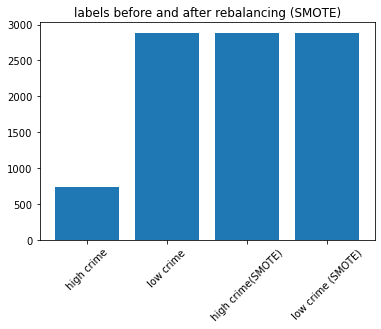

In [19]:
# create feature list without income_deprivation and employment_deprivation
feature_list = ['income_deprivation_score',
                'employment_deprivation_score',
                'child_income_deprivation_score',
                'lone_parent_pct',
                'homeowner_mortgage_pct',
                'rent_private_pct',
                'no_qualifications_pct',
                'degree_educated_pct',
                'log_rent_social_pct',
                'log_ethnic_other_pct',
                'log_population_density',
                'log_ethnic_black_pct',
                'log_ethnic_asian_pct',
                'log_median_house_price',
                'high_violence']

cohort_size = 1000
dataset = create_snapshot(violence_features_master, cohort_size, feature_list)
train_features, test_features, train_labels, test_labels, X_resampled, y_resampled = get_test_train_data(dataset)

In [20]:
import time
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 3, 5],
    'max_features': [3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [500, 1000, 2000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
gs_rf = GridSearchCV(estimator = rf, param_grid = param_grid, refit=True,
                          cv = 3, n_jobs = -1, verbose = 2)

tic = time.perf_counter()
gs_rf.fit(X_resampled, y_resampled)
toc = time.perf_counter()

print(f"Running the Random Forest classifer on our best features dataset took {toc - tic:0.4f} seconds")

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Running the Random Forest classifer on our best features dataset took 342.2856 seconds


In [21]:
# we used refit=True which means the GridSearch returns the best model already trained
y_pred = gs_rf.predict(test_features)

------------------------------------------------------------------
Printing performance metrics for optimal model
------------------------------------------------------------------

prediction accuracy 0.6942833471416736
precision 0.40229885057471265
recall 0.7865168539325843
Area under the curve score 0.7273009801577814




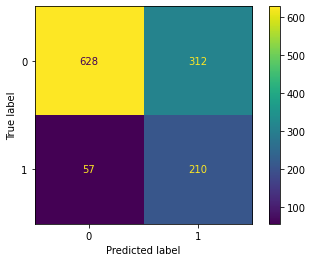

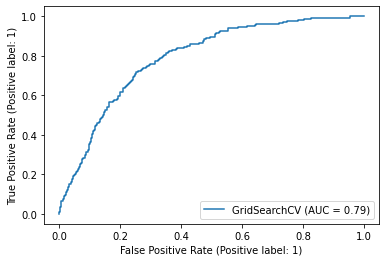

In [22]:
accuracy, precision, recall, roc_auc, tn, fp, fn, tp = RF_performance_reporting(gs_rf, 
                                                                                test_features, 
                                                                                test_labels, 
                                                                                y_pred, 
                                                                                'optimal model', 
                                                                                print_output=True)

## Comments
The recall is good, because it means that the model predicts a high crime area 79% of the time. However, the downside is the model is too quick to predict a high crime area, because it will falsely predict a high crime area six times out of ten. This means that it's a toss up between this optimised model and Option 6 model, which had a better precision. In both cases however, the model does have moderate predictive power as evidenced by an AUC score of about 0.72.

The final step is to check which are the most important features in this final model to see whether they are the same as in Option 6
- we need to recreat the model using the best parameters because our features_importance function doesn't work with a cross validated model returned by a grid search

In [23]:
gs_rf.best_params_

{'bootstrap': True,
 'max_depth': 5,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 500}

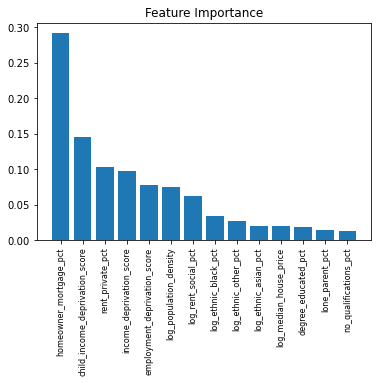

In [24]:
rf_final = RandomForestClassifier(n_estimators = 500, oob_score = True,
                           bootstrap = True, random_state = 42, max_depth=5, 
                           max_features=4, min_samples_leaf=3, min_samples_split=8)

# Train the model on training data
rf_final.fit(X_resampled, y_resampled)

feature_importance(rf_final, dataset)

## Conclusions
We can produce a reasonable predictor for areas with high serious violent crime and the most important features for these best predictors are:
- homeownership levels
- child deprivation
- the proportion of private rental
- income deprivation
- log(population density)

Which are interesting when compared to the spearman correlations we calculated previously (except for private rental)

<img src="spearman_correlations.png">